# GTSF phase: biomass prediction

In this notebook, we are forecasting the weights by finding the closest blender model

### Look at the volumes created with blender

Load blender data

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
import tempfile
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from scipy.stats import norm
import tqdm
import pickle
from itertools import combinations

from PIL import Image, ImageDraw
from multiprocessing import Pool, Manager
import copy
import uuid





<h1> Get world keypoint coordinates from GTSF data </h1>

In [8]:
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


sql_credentials = json.load(open(os.environ["SQL_CREDENTIALS"]))
sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                           sql_credentials["host"], sql_credentials["port"],
                           sql_credentials["database"]))

Session = sessionmaker(bind=sql_engine)
session = Session()

Base = automap_base()
Base.prepare(sql_engine, reflect=True)
Enclosure = Base.classes.enclosures
Calibration = Base.classes.calibrations
GtsfDataCollection = Base.classes.gtsf_data_collections
StereoFramePair = Base.classes.stereo_frame_pairs


<h1> Utility functions for world keypoint normalization </h1>

In [9]:
def generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

In [10]:
def euclidean_distance(p1, p2):
    if type(p1) == list:
        p1 = np.array(p1)
    if type(p2) == list:
        p2 = np.array(p2)
    return np.linalg.norm(p1 - p2)


def normalize_world_keypoints(wkps):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['TAIL_NOTCH'] for bp in body_parts}
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp]) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['DORSAL_FIN'] - np.array([norm_wkps_intermediate['DORSAL_FIN'][0], 0, 0])
    R = generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    # perform reflecton if necessary
    if norm_wkps['PECTORAL_FIN'][1] > 0:
        norm_wkps = {bp: np.array([
            norm_wkps[bp][0],
            -norm_wkps[bp][1],
            norm_wkps[bp][2]
        ]) for bp in body_parts}
    
    return norm_wkps
    



<h1> Utility Method: World Keypoint Calculation </h1>

In [11]:
# DEFINE OPTICAL PROPERTIES

# all distance are in meters
FOCAL_LENGTH = 0.00843663
BASELINE = 0.128096
PIXEL_SIZE_M = 3.45 * 1e-6
FOCAL_LENGTH_PIXEL = FOCAL_LENGTH / PIXEL_SIZE_M
IMAGE_SENSOR_WIDTH = 0.01412
IMAGE_SENSOR_HEIGHT = 0.01035
PIXEL_COUNT_WIDTH = 4096
PIXEL_COUNT_HEIGHT = 3000

def convert_to_world_point(x, y, d):
    """ from pixel coordinates to world coordinates """
    
    image_center_x = PIXEL_COUNT_WIDTH / 2.0  
    image_center_y = PIXEL_COUNT_HEIGHT / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y

    sensor_x = px_x * (IMAGE_SENSOR_WIDTH / PIXEL_COUNT_WIDTH)
    sensor_z = px_z * (IMAGE_SENSOR_HEIGHT / PIXEL_COUNT_HEIGHT)

    # d = depth_map[y, x]
    world_y = d
    world_x = (world_y * sensor_x) / FOCAL_LENGTH
    world_z = (world_y * sensor_z) / FOCAL_LENGTH
    return np.array([world_x, world_y, world_z])

def depth_from_disp(disp):
    """ calculate the depth of the point based on the disparity value """
    depth = FOCAL_LENGTH_PIXEL*BASELINE / np.array(disp)
    return depth

def disp_from_depth(depth):
    disp = FOCAL_LENGTH_PIXEL * BASELINE / depth
    return disp


<h1> Generate accuracy metrics on GTSF data </h1>

<h1> Train linear model with PCA + all raw features </h1>

In [54]:
df = pd.DataFrame()
sfps_all = session.query(StereoFramePair).all()

session.rollback()
for idx, row in enumerate(sfps_all):
    if idx % 10 == 0:
        print(idx)
        
    # get fish_id and ground truth metadata
    if row.gtsf_fish_identifier == '190321010002':
        continue
    gtsf_data_collection_id = row.gtsf_data_collection_id
    gtsf_data_collection = session.query(GtsfDataCollection).get(gtsf_data_collection_id)
    ground_truth_metadata = json.loads(gtsf_data_collection.ground_truth_metadata)
    if ground_truth_metadata['data'].get('species') != 'salmon':
        continue
    
    world_keypoints = json.loads(row.world_keypoint_coordinates)
    body_parts = list(world_keypoints.keys())
    wkps = {bp: np.array(world_keypoints[bp]) for bp in body_parts}
#     norm_wkps = normalize_world_keypoints(wkps)
#     body_wkp = world_keypoints['BODY'].mean(axis=0)
#     wkps = copy.copy(world_keypoints)
#     wkps['BODY'] = body_wkp
    
    row = {'0': idx}
#     for i in range(len(body_parts)-1):
#         for j in range(i+1, len(body_parts)):
#             d = euclidean_distance(wkps[body_parts[i]], wkps[body_parts[j]])
#             row['{0}-{1}'.format(i, j)] = d

    for bp in body_parts:
        row['{}_x'.format(bp)] = wkps[bp][0]
        row['{}_y'.format(bp)] = wkps[bp][1]
        row['{}_z'.format(bp)] = wkps[bp][2]
    
    weight = ground_truth_metadata['data']['weight']
    length = ground_truth_metadata['data']['length']
    width = ground_truth_metadata['data']['width']
    breadth = ground_truth_metadata['data']['breath']
    row['weight'] = weight
    row['length'] = length
    row['width'] = width
    row['breadth'] = breadth
    row['kfactor'] = 1e5 * weight / length**3
    df = df.append(row, ignore_index=True)
            
    
df_cache = df.copy()
df = df.dropna()


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660


In [16]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    


In [40]:
# define all features

# body_parts = list(wkps.keys())
body_parts = [
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
]

columns = []
for bp in body_parts:
    for axis in ['x', 'y', 'z']:
        columns.append('{0}_{1}'.format(bp, axis))
        
# interaction_columns = []
# for i in range(len(pairwise_distance_columns)):
#     for j in range(i, len(pairwise_distance_columns)):
#         col1 = pairwise_distance_columns[i]
#         col2 = pairwise_distance_columns[j]
#         interaction_column = '{},{}'.format(col1, col2)
#         df[interaction_column] = df[col1] * df[col2]
#         interaction_columns.append(interaction_column)

In [48]:
mask = generate_train_mask(df, train_frac=0.8)

X = df[columns].values
X_train = df.loc[mask, columns].values
y_train = df.loc[mask, 'weight'].values
X_test = df.loc[~mask, columns].values
y_test = df.loc[~mask, 'weight'].values

# pca = PCA(n_components=min(X_train.shape[0], X_train.shape[1]))
# pca.fit(X_train)
# explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
# idx = np.where(explained_variance_ratio > 0.99999)[0][0]
# pca = PCA(n_components=idx+1)
# pca.fit(X_train)
# X_train_modified = pca.transform(X_train)
# X_test_modified = pca.transform(X_test)

# reg = LinearRegression().fit(X_train_modified, y_train)
# print(reg.score(X_test_modified, y_test))

# y_pred = reg.predict(pca.transform(df[columns].values))

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X)


df['prediction'] = y_pred
df['error'] = df.prediction - df.weight
df['error_pct'] = df.error / df.weight
df['abs_error_pct'] = df.error_pct.abs()


In [53]:
((df['error']**2).mean())**.5

133.42630391140003

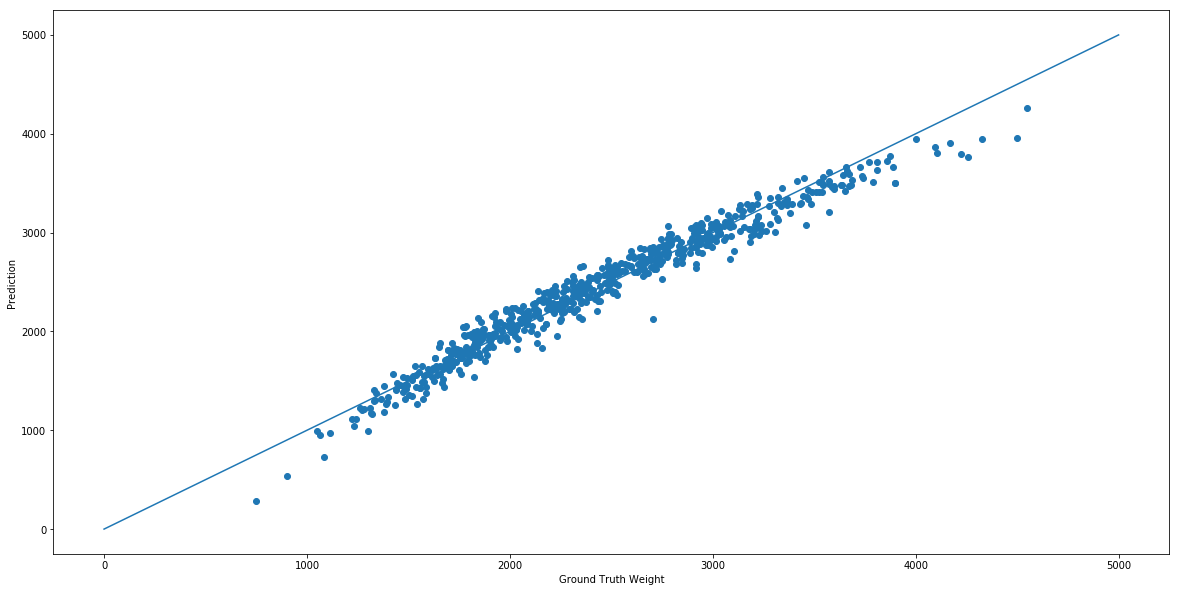

In [49]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.scatter(df.weight, df.prediction)
plt.xlabel('Ground Truth Weight')
plt.ylabel('Prediction')
plt.plot(range(5000), range(5000))


KeyError: 'the label [width] is not in the [columns]'

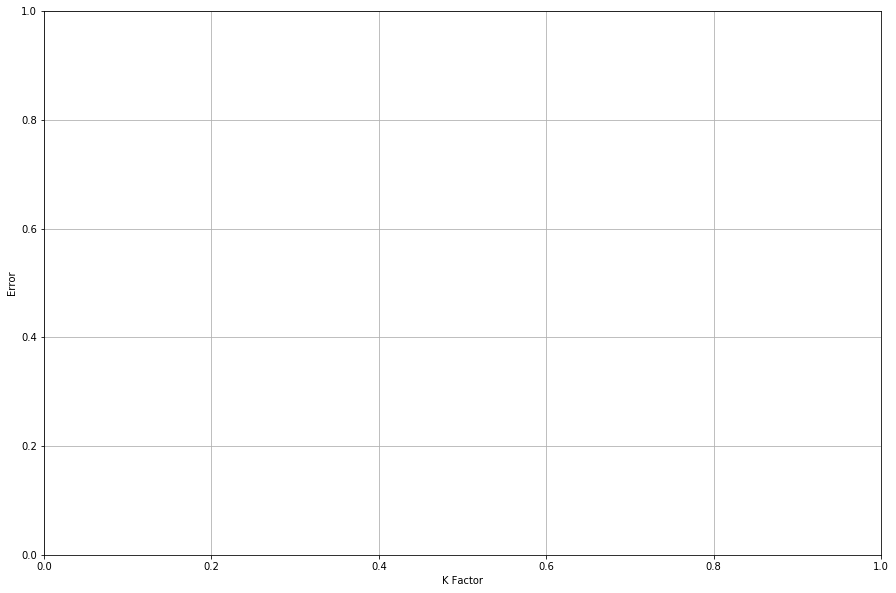

In [317]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.xlabel('K Factor')
plt.ylabel('Error')
plt.scatter(df.loc[~mask, ''], df.loc[~mask, 'error'])


In [280]:
N = 1000

# perform N-fold cross validation
abs_err_pcts = []
for i in range(N):
    if i % 10 == 0:
        print(i)
    mask = generate_train_mask(df, train_frac=0.615)

    columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(list(range(8)), 2))]
    X_train = df.loc[mask, columns].values
    y_train = df.loc[mask, 'weight'].values
    X_test = df.loc[~mask, columns].values
    y_test = df.loc[~mask, 'weight'].values

    pca = PCA(n_components=min(X_train.shape[0], X_train.shape[1]))
    pca.fit(X_train)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    idx = np.where(explained_variance_ratio > 0.9999)[0][0]

    pca = PCA(n_components=idx+1)
    pca.fit(X_train)
    X_train_modified = pca.transform(X_train)
    X_test_modified = pca.transform(X_test)
    reg = LinearRegression().fit(X_train_modified, y_train)


    y_pred = reg.predict(pca.transform(df[columns].values))
    df['prediction'] = y_pred
    df['error'] = df.prediction - df.weight
    df['error_pct'] = df.error / df.weight
    df['abs_error_pct'] = df.error_pct.abs()

    
    avg_biomass_err = df.loc[~mask, 'prediction'].mean() - df.loc[~mask, 'weight'].mean()
    abs_err_pct = abs(avg_biomass_err) / df.loc[~mask, 'weight'].mean()
    abs_err_pcts.append(abs_err_pct)
    
    



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


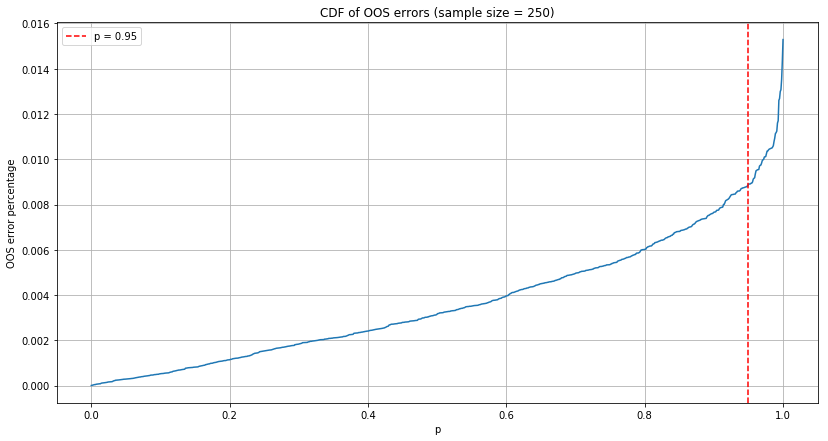

In [281]:
data_sorted = sorted(list(abs_err_pcts))
p = 1.0 * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
fig = plt.figure(figsize=(30, 7))
ax1 = fig.add_subplot(121)
ax1.plot(p, data_sorted)
ax1.set_xlabel('p')
ax1.set_ylabel('OOS error percentage')
plt.axvline(x=0.95, linestyle='--', color='red', label='p = 0.95')
plt.title('CDF of OOS errors (sample size = 250)')
plt.legend()
plt.grid()

